In [1]:
import dynamo as dyn
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
from scipy.sparse import csr_matrix
import scipy
import anndata as ad
from sklearn.neighbors import NearestNeighbors
from statsmodels.nonparametric.kernel_regression import KernelReg

# progress bar
import contextlib
import joblib
from tqdm import tqdm
def export_velocity_to_dynamo(cellDancer_df,adata):
    '''
    Replace the velocities in adata of dynamo (“adata” in parameters) with the cellDancer predicted velocities (“cellDancer_df” in parameters). The output can be directly used in the downstream analyses of dynamo.

    -------
    The vector field could be learned by dynamo based on the RNA velocity of cellDancer. Details are shown in the section ‘Application of dynamo.’
    
    .. image:: _static/dynamo_vector_field_pancreas.png
      :width: 60%
      :alt: dynamo_vector_field_pancreas

    Arguments
    ---------
    cellDancer_df: `pandas.DataFrame`
        The output dataframe of cellDancer. 

        cellDancer                  -->     dynamo

        bools of the existance of cellDancer_df['gene_name'] in adata.var      -->     adata.var['use_for_dynamics']

        bools of the existance of cellDancer_df['gene_name'] in adata.var      -->     adata.var['use_for_transition']

        cellDancer_df.splice_predict - cellDancer_df.splice                    -->    adata.layers['velocity_S']

    adata: `anndata._core.anndata.AnnData`
        The adata to be integrated with cellDancer velocity result.


    Returns 
    -------
    adata
    '''

    dancer_genes = cellDancer_df['gene_name'].drop_duplicates()
    cellDancer_df["velocity_S"] = cellDancer_df["splice_predict"]-cellDancer_df["splice"]
    dancer_velocity_s = cellDancer_df[['cellID', 'gene_name', 'velocity_S']]
    pivoted = dancer_velocity_s.pivot(index="cellID", columns="gene_name", values="velocity_S")
    velocity_matrix = np.zeros(adata.shape)
    adata_ds_zeros = pd.DataFrame(velocity_matrix, columns=adata.var.index, index=adata.obs.index)
    celldancer_velocity_s_df = (adata_ds_zeros + pivoted).fillna(0)[adata.var.index]

    adata.layers['velocity_S'] = scipy.sparse.csr_matrix(celldancer_velocity_s_df.values)
    adata.var['use_for_dynamics'] = adata.var.index.isin(dancer_genes)
    adata.var['use_for_transition'] = adata.var.index.isin(dancer_genes)
    return(adata.copy())


In [2]:
Macro_2 =  ad.read_h5ad("/home/yang/PM_AD/Submission/Figure5/Macro_2_data_20_3000.h5ad")

/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
# List of layers to keep
keep_layers = ['matrix','spliced', 'unspliced']

# Remove layers except the ones to keep
Macro_2.layers = {key: value for key, value in Macro_2.layers.items() if key in keep_layers}

if 'recover_dynamics' in Macro_2.uns:
    del Macro_2.uns['recover_dynamics']

In [4]:
adata_dyn = Macro_2.copy()

In [5]:
gene = pd.read_excel("Module_table.xlsx", index_col=2)

In [6]:
gene.head()

Unnamed: 0.1             Unnamed: 0 modularity_class           X  \
Label                                                                     
LYVE1             0  LYVE1_ENSG00000133800                A   26.665518   
F13A1             1  F13A1_ENSG00000124491                A  -28.709587   
FOLR2             2  FOLR2_ENSG00000165457                A   98.792931   
C1QC              3   C1QC_ENSG00000159189                A  105.773705   
LY96              4   LY96_ENSG00000154589                A  218.635696   

                Y  Size    Color            ENSEM  
Label                                              
LYVE1  -13.279196    10  #ee7993  ENSG00000133800  
F13A1   -1.283960    10  #ee7993  ENSG00000124491  
FOLR2  101.810081    10  #ee7993  ENSG00000165457  
C1QC    56.785320    10  #ee7993  ENSG00000159189  
LY96   -27.194592    10  #ee7993  ENSG00000154589

In [7]:
module_genes = gene.index.tolist()
dyn.pp.recipe_monocle(adata_dyn, n_top_genes=3000, fg_kwargs={"shared_count": 20}, genes_to_append=module_genes)
dyn.tl.moments(adata_dyn)
dyn.tl.dynamics(adata_dyn, model='deterministic')


|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----? dynamo detects your data is size factor normalized and/or log transformed. If this is not right, plese set `normalized = False.
|-----> filtering cells...
|-----> 2044 cells passed basic filters.
|-----> filtering gene...


/tmp/ipykernel_100198/2741179446.py:2: DeprecationWarning: recipe_monocle is deprecated and will be removed in a future release. Please update your code to use the new replacement function.
  dyn.pp.recipe_monocle(adata_dyn, n_top_genes=3000, fg_kwargs={"shared_count": 20}, genes_to_append=module_genes)


|-----> 3778 genes passed basic filters.
|-----> calculating size factor...
|-----> selecting genes in layer: X, sort method: SVR...
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [8.4450s]
|-----> [Cell Cycle Scores Estimation] completed [0.1643s]
|-----> [recipe_monocle preprocess] completed [2.5650s]
|-----> calculating first/second moments...
|-----> [moments calculation] completed [10.6339s]
|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False


estimating gamma: 100%|█████████████████████████████████████████████████████████████████████████████| 2982/2982 [01:13<00:00, 40.73it/s]


AnnData object with n_obs × n_vars = 2044 × 4707
    obs: 'Status', 'Site', 'Tissue', 'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage', 'final_clustering', 'n_genes', 'Annotation', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'leiden', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'feature_types-SKN8090524', 'gene_ids-SKN8090525', 'feature_types-SKN8090525', 'gene_ids-SKN8090526', 'feature_types-SKN8090526', 'gene_ids-SKN8090527', 'feature_types-SKN8090527', 'gene_ids-SKN8090528', 'feature_types-SKN8090528', 'gene_ids-SKN8090529', 'feature_types-SKN8090529', 'gene_ids-SKN8090530', 'feature_types-SKN8090530', 'gene_ids-SKN8090531', 'feature_types-SKN8090531', 'g

In [8]:
cellDancer_df = pd.read_csv("/home/yang/PM_AD/Submission/Code/scRNA_seq/RNA_velocity/cellDancer_velocity_2025-02-04 14-00-33/cellDancer_estimation.csv", index_col=0) # Module A

In [9]:
adata = export_velocity_to_dynamo(cellDancer_df,adata_dyn)

In [10]:
adata

AnnData object with n_obs × n_vars = 2044 × 4707
    obs: 'Status', 'Site', 'Tissue', 'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage', 'final_clustering', 'n_genes', 'Annotation', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'leiden', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'feature_types-SKN8090524', 'gene_ids-SKN8090525', 'feature_types-SKN8090525', 'gene_ids-SKN8090526', 'feature_types-SKN8090526', 'gene_ids-SKN8090527', 'feature_types-SKN8090527', 'gene_ids-SKN8090528', 'feature_types-SKN8090528', 'gene_ids-SKN8090529', 'feature_types-SKN8090529', 'gene_ids-SKN8090530', 'feature_types-SKN8090530', 'gene_ids-SKN8090531', 'feature_types-SKN8090531', 'g

In [11]:
colormap1 = {'0': '#0000FF',  # Blue
             '1': '#FFA500',  # Orange
             '2': '#008000',  # Green
             '3': '#FF0000',  # Red
             '4': '#800080',  # Purple
             '5': '#A52A2A'}  # Brown

In [12]:
dyn.tl.reduceDimension(adata, n_pca_components=30)
dyn.tl.cell_velocities(adata, method="pearson", other_kernels_dict={"transform": "sqrt"})
dyn.tl.cell_velocities(adata, basis="pca")

|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [UMAP] completed [0.0010s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [1.0109s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.6484s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.7731s]
|-----> method arg is None, choosing methods automatically...

AnnData object with n_obs × n_vars = 2044 × 4707
    obs: 'Status', 'Site', 'Tissue', 'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage', 'final_clustering', 'n_genes', 'Annotation', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'leiden', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'feature_types-SKN8090524', 'gene_ids-SKN8090525', 'feature_types-SKN8090525', 'gene_ids-SKN8090526', 'feature_types-SKN8090526', 'gene_ids-SKN8090527', 'feature_types-SKN8090527', 'gene_ids-SKN8090528', 'feature_types-SKN8090528', 'gene_ids-SKN8090529', 'feature_types-SKN8090529', 'gene_ids-SKN8090530', 'feature_types-SKN8090530', 'gene_ids-SKN8090531', 'feature_types-SKN8090531', 'g

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering leiden by stack threshold when stacking color because it is not a numeric type


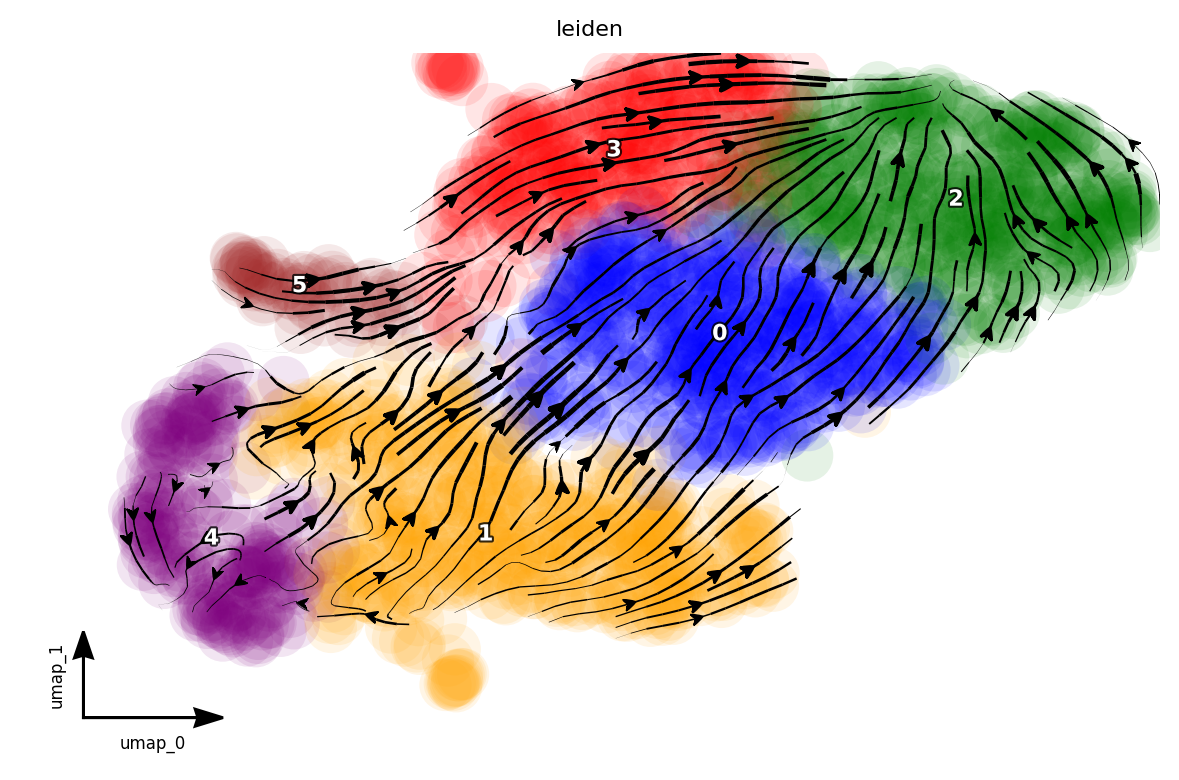

In [13]:
dyn.pl.streamline_plot(adata, color=["leiden"], basis="umap", show_legend="on data", show_arrowed_spines=True, color_key=colormap1) 

/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


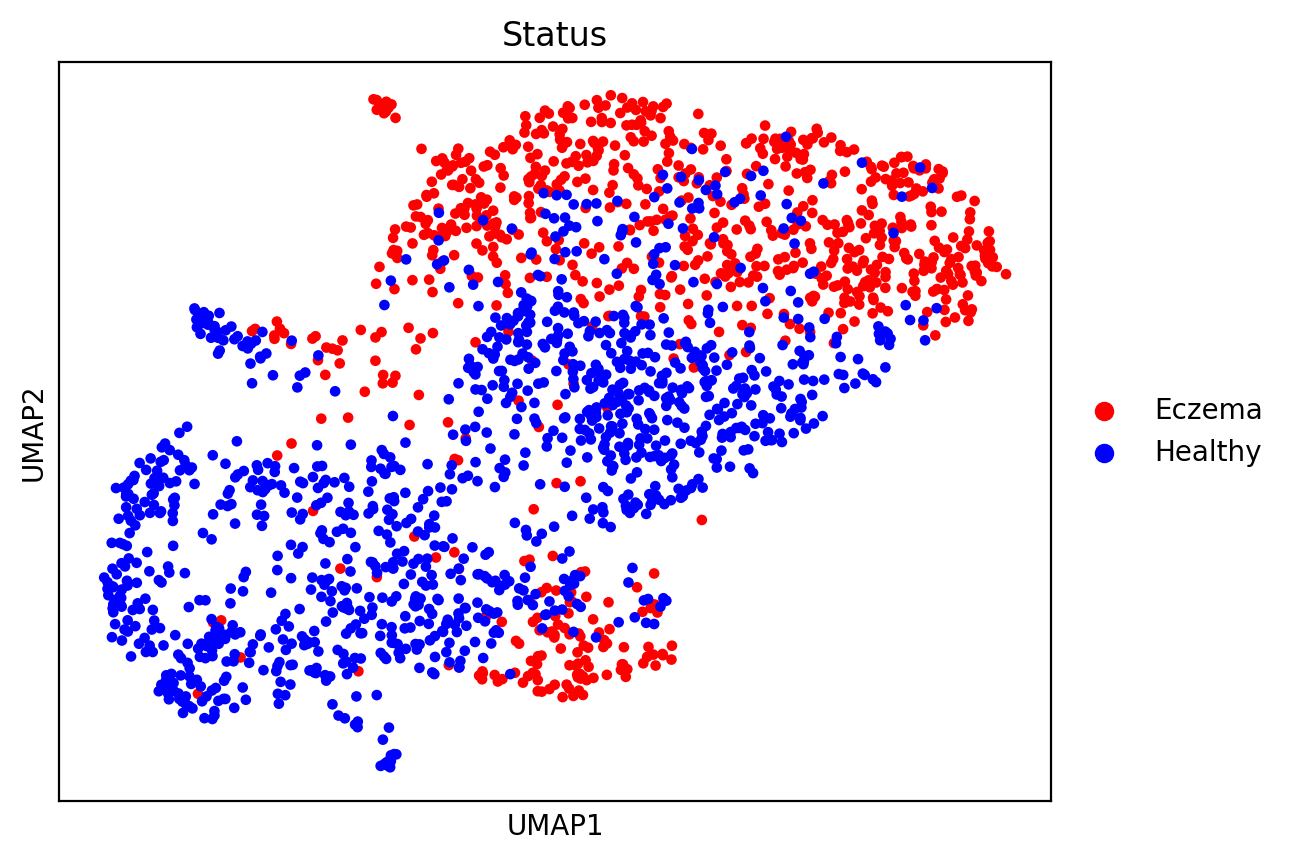

In [14]:
sc.pl.embedding(
     Macro_2,
     basis="umap",
     frameon=True,
     color=['Status'],
     palette=['red', 'blue'])

/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


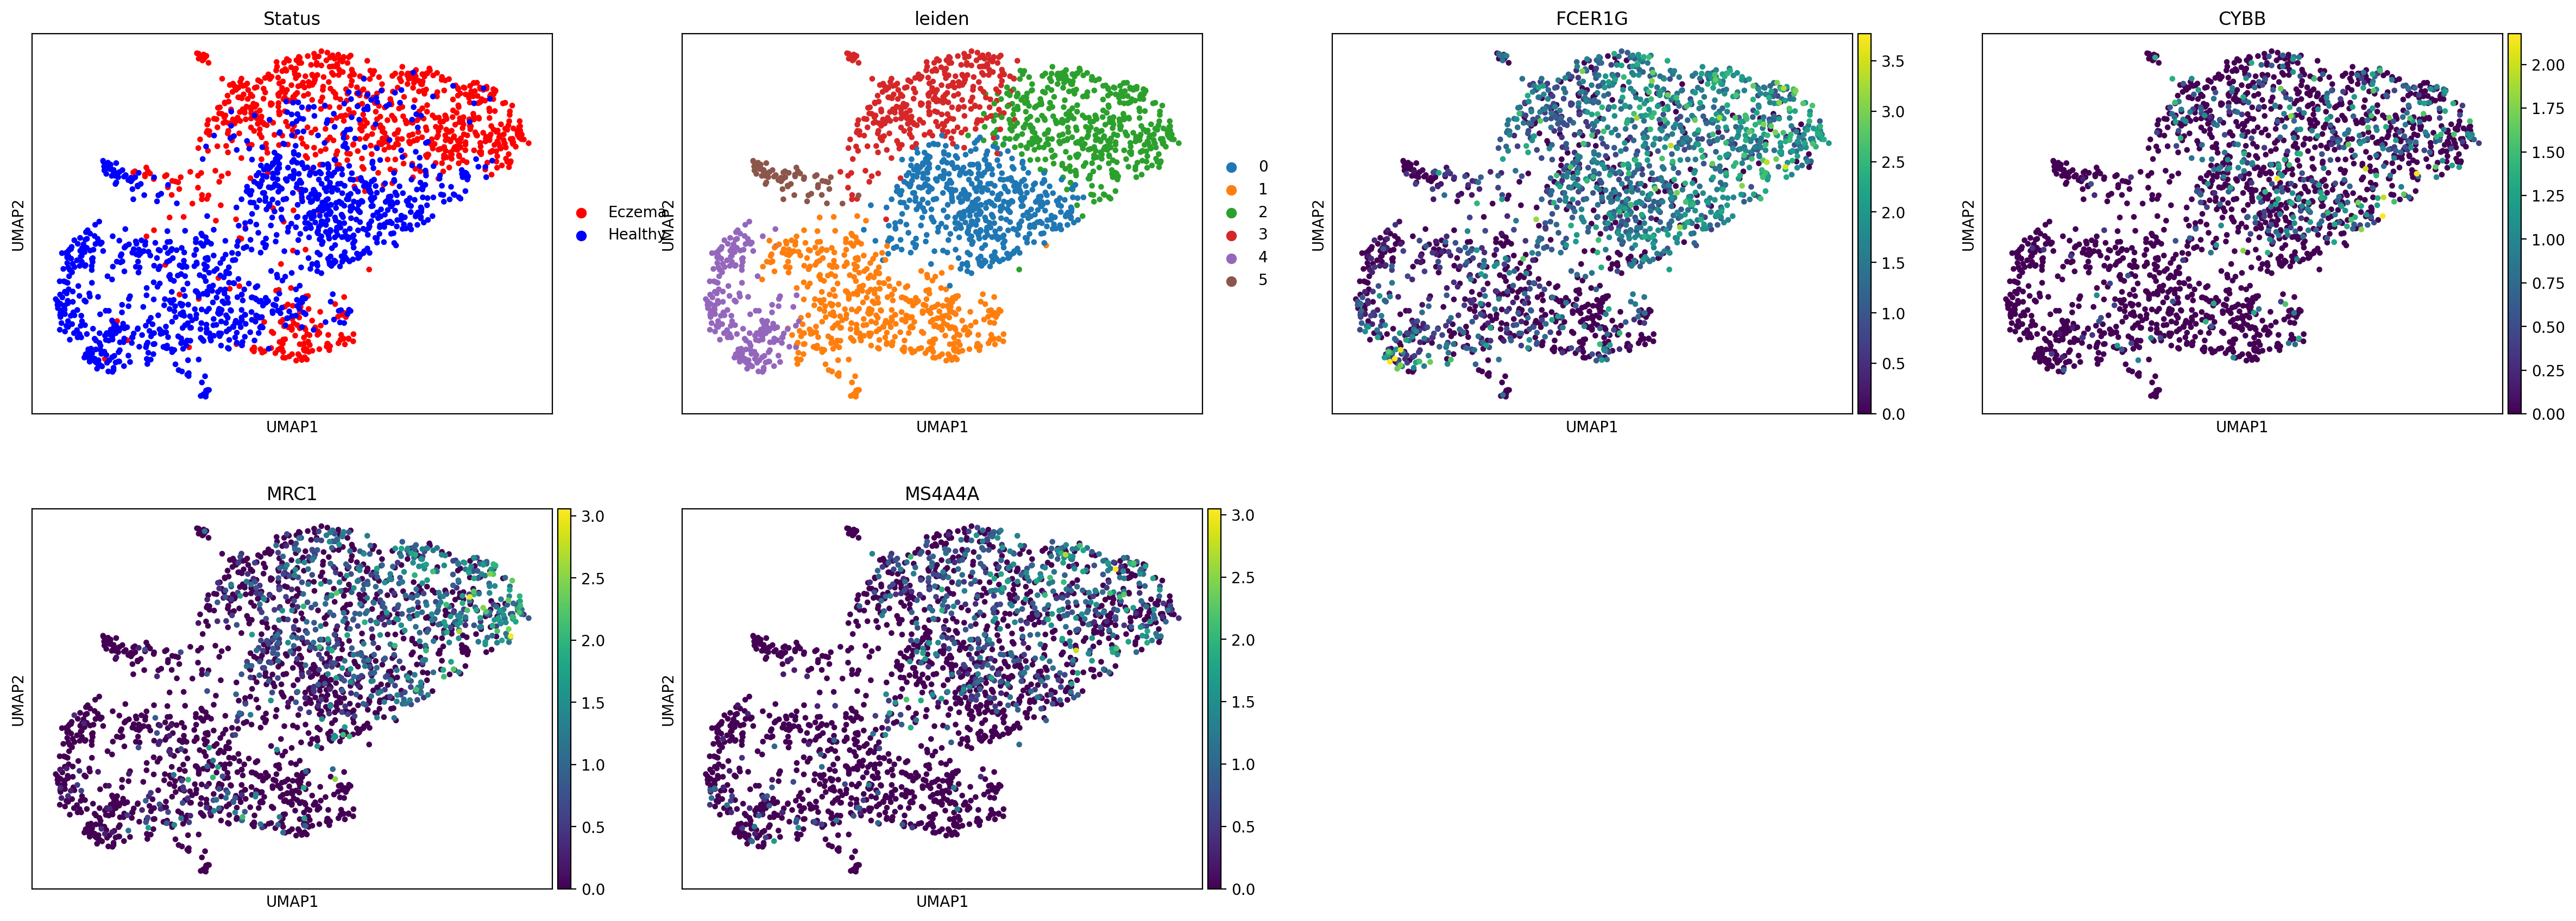

In [15]:
import matplotlib.pyplot as plt
import scanpy as sc

# Set rcParams to ensure text is editable in PDF
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.embedding(
     Macro_2,
     basis="umap",
     frameon=True,
     color=['Status','leiden','FCER1G','CYBB','MRC1','MS4A4A']) 
     # save= 'Macro_1_umap.pdf')

### Calculate Module score

In [16]:
a = dyn.tl.score_cells(adata, genes =gene[gene.modularity_class == 'A'].index.tolist())
adata.obs['Module_A_score'] = a

|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected


|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap


<Figure size 1500x600 with 0 Axes>

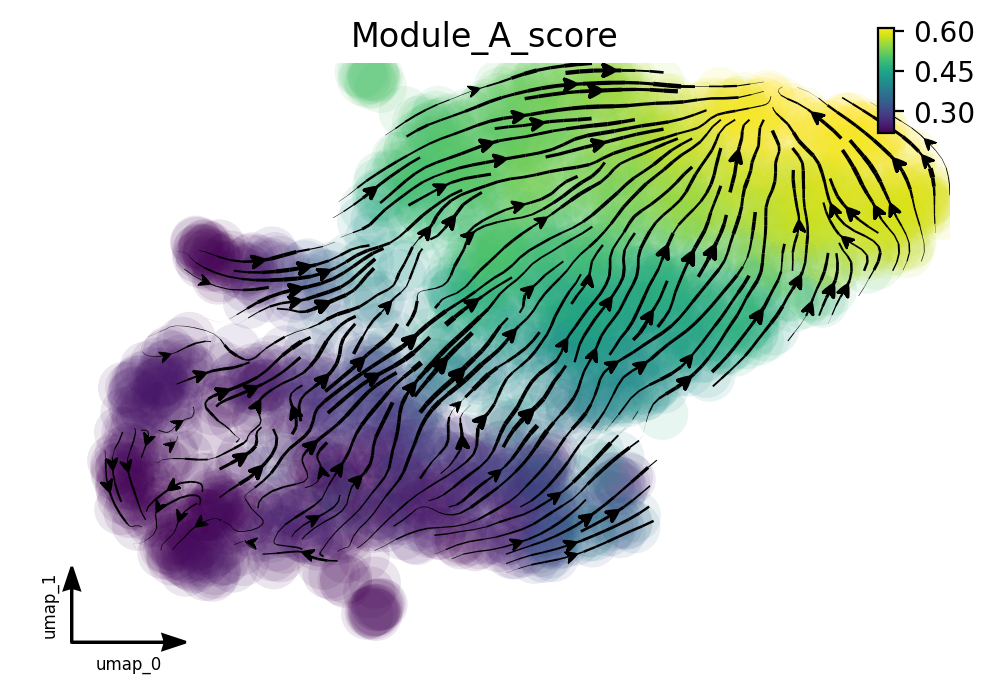

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Create a new figure with specified figsize
plt.figure(figsize=(15, 6))  # Adjust the width and height as needed

# Call the streamline_plot function and receive the graph object
axes = dyn.pl.streamline_plot(
    adata, 
    color=["Module_A_score"], 
    basis="umap", 
    show_legend=False,  # Do not display the legend on top of the data
    show_arrowed_spines=True,
    save_show_or_return="return"  # Set to 'return' to receive the axes
)

plt.show()  # Display the current plot


### Estimate vectorfield

In [18]:
dyn.vf.VectorField(adata, basis='pca', M=100, method = "SparseVFC")
dyn.vf.VectorField(adata, basis="umap", pot_curl_div=True)

dyn.vf.speed(adata, basis="pca")
dyn.vf.divergence(adata, basis="pca")
dyn.vf.acceleration(adata, basis="pca")
dyn.vf.curl(adata, basis="umap")

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [SparseVFC] completed [0.1914s]
|-----> [VectorField] completed [0.3305s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [SparseVFC] completed [1.9803s]
|--

Calculating 2-D curl: 100%|██████████████████████████████████████████████████████████████████████| 2044/2044 [00:00<00:00, 15042.00it/s]

|-----> Computing divergence...



Calculating divergence: 100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 43.91it/s]

|-----> [VectorField] completed [4.7592s]



Calculating divergence: 100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.44it/s]


|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.2172s]


Calculating 2-D curl: 100%|██████████████████████████████████████████████████████████████████████| 2044/2044 [00:00<00:00, 25782.23it/s]


### Dynamo version pseudotime

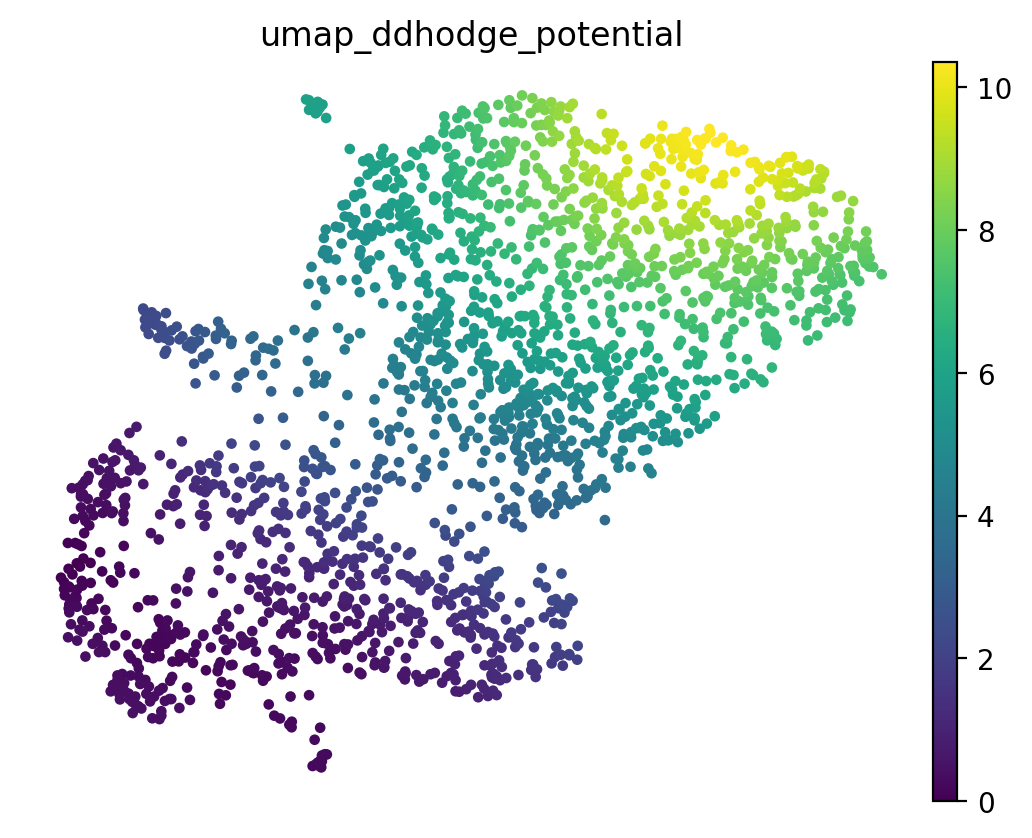

In [19]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.embedding(
     adata,
     basis="umap",
     frameon=False,
     color=['umap_ddhodge_potential'])

### State transition graph

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree parameter preparation computation] in progress: 0.0000%|-----> [KDTree computation] completed [0.0006s]
|-----> [iterate groups] in progress: 16.6667%

uniformly sampling points along a trajectory: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 264.74it/s]


|-----> [iterate groups] in progress: 33.3333%

/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/dynamo/prediction/state_graph.py:320: RuntimeWarning: invalid value encountered in divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 259.31it/s]


|-----> [iterate groups] in progress: 50.0000%

/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/dynamo/prediction/state_graph.py:320: RuntimeWarning: invalid value encountered in divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 258.69it/s]


|-----> [iterate groups] in progress: 66.6667%

/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/dynamo/prediction/state_graph.py:320: RuntimeWarning: invalid value encountered in divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 250.27it/s]


|-----> [iterate groups] in progress: 83.3333%

/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/dynamo/prediction/state_graph.py:320: RuntimeWarning: invalid value encountered in divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 292.76it/s]


|-----> [iterate groups] in progress: 100.0000%

/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/dynamo/prediction/state_graph.py:320: RuntimeWarning: invalid value encountered in divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|████████████████████████████████████████████████████| 65/65 [00:00<00:00, 265.92it/s]


|-----> [iterate groups] completed [54.3787s]
|-----> [State graph estimation] completed [0.0022s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Status by stack threshold when stacking color because it is not a numeric type


/home/yang/anaconda3/envs/cellDancer/lib/python3.8/site-packages/dynamo/prediction/state_graph.py:320: RuntimeWarning: invalid value encountered in divide
  grp_avg_time[i, :] /= grp_graph[i, :]


<Figure size 640x480 with 0 Axes>

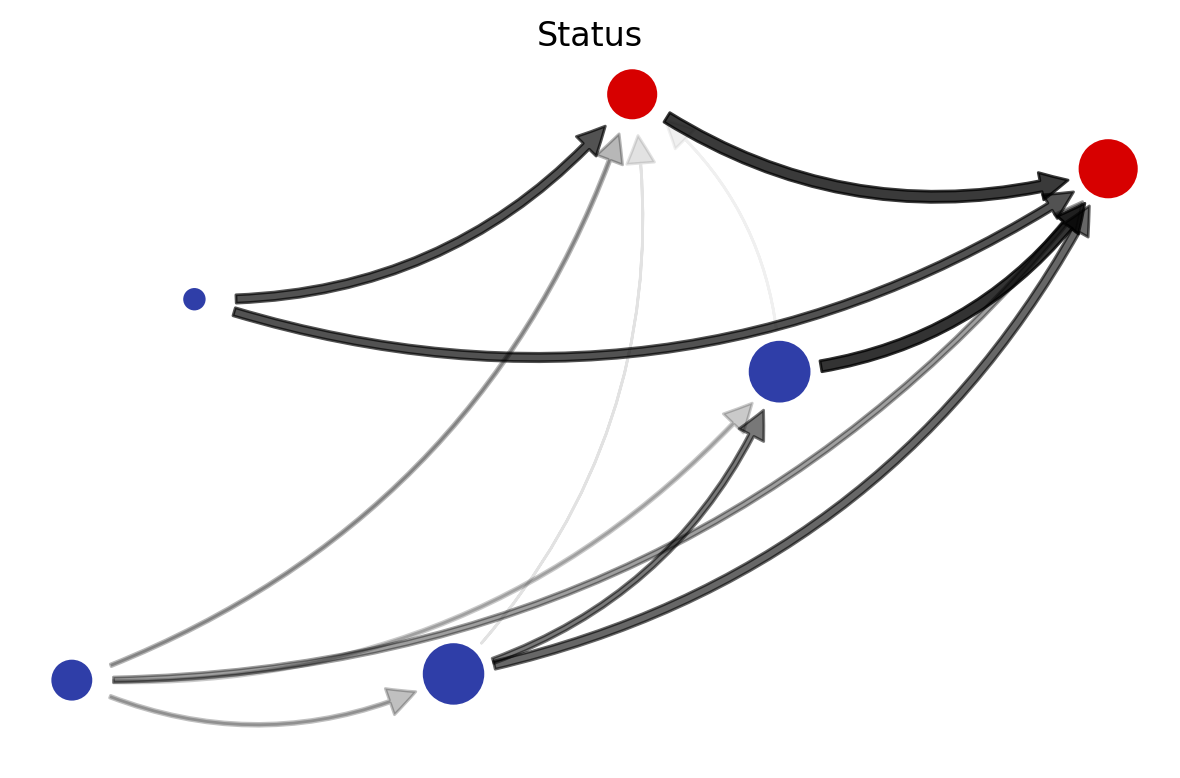

In [20]:
dyn.pd.state_graph(adata, group='leiden', basis='umap', method='vf')

dyn.pl.state_graph(adata,
                   color=['Status'],
                   group='leiden',
                   basis='umap',
                   show_legend=False,
                   method='vf');

In [ ]:
# adata.write_h5ad("To_create_plot_gene_trend.h5ad")